In [1]:
def launch_selenium(names_list):
    from selenium import webdriver
    from selenium.webdriver.common.keys import Keys
    from selenium.webdriver.support import expected_conditions as EC
    
    import os
    import time
    import SENSITIVE as SENS
    
    # mv chrome driver from Downloads to Applications 
    chromedriver = "/Applications/chromedriver"
    os.environ["webdriver.chrome.driver"] = chromedriver

    url = 'https://pro-labs.imdb.com/name/' + names_list[0] + '/'
    
    driver = webdriver.Chrome(chromedriver)
    driver.get(url)
    
    loginButton = driver.find_element_by_xpath('//a[@class="log_in"]')
    loginButton.click()

    time.sleep(.5)
    loginButton = driver.find_element_by_xpath('//input[@id="auth-lwa-button"]')
    loginButton.click()

    time.sleep(.5)
    username_form = driver.find_element_by_id("ap_email")
    username_form.send_keys(SENS.username)

    password_form=driver.find_element_by_id('ap_password')
    password_form.send_keys(SENS.password)

    password_form.send_keys(Keys.RETURN)
    
    return driver


def get_actor_rankings(driver, name_list):
    #Selenium is a web browser testing automation tool
    from selenium import webdriver
    from selenium.webdriver.common.keys import Keys
    from selenium.webdriver.support import expected_conditions as EC

    import time
    import SENSITIVE as SENS
    from IPython.display import clear_output
    import datetime
    import matplotlib.pyplot as plt
    %matplotlib inline
    import pandas as pd

    import os
    import pickle
    
    
    # Load temporary pickle to store data and avoid repeats
    try:
        with open("star_scrape_progress.pkl", 'rb') as picklefile:
            df = pickle.load(picklefile)
    except:
        df = []
        
    cur_idx = 0
    for name_id in name_list:
        cur_idx += 1
        if (len(df) > 0) and (name_id in df['nconst'].values):
#             print('%s already in data.' % name_id)
            continue
        print("(%d/%d)" % (cur_idx, len(name_list)))
        url = 'https://pro-labs.imdb.com/name/' + name_id + '/'
        print("Fetching URL: " + url)
        driver.get(url+'graph/')

#         time.sleep(.5)
#         starMeterButton = driver.find_element_by_xpath('//span[text()="STARmeter"]')
#         starMeterButton.click()

#         time.sleep(.5)

        try:
            five_year = driver.find_element_by_id('five_years')
            five_year.click()
        except:
            df_tmp = pd.DataFrame([[name_id, '', '', '', 'UNAVAILABLE']], columns=['nconst', 'Name', 'Start Date', 'End Date', 'Star Ranking'])
            if len(df) == 0:
                df = df_tmp
            else:
                df = df.append(df_tmp)
            continue

        graph_div = driver.find_element_by_id('ranking_graph')

        location = graph_div.find_elements_by_tag_name('rect')[1:]

        name = driver.find_elements_by_class_name('display-name')[1].find_element_by_tag_name('a').text

        star_meter_data = []
        for i in range(1, len(location)+1):
    #         clear_output(wait=True)
#             print(i)
            loc = graph_div.find_elements_by_tag_name('rect')[i]
            driver.find_element_by_class_name('current_rank').find_element_by_tag_name('span').click()
        #     time.sleep(.1)
            try:
                loc.click()
            except:
                time.sleep(0.5)
            g = graph_div.find_elements_by_tag_name('tspan')[-2:]
        #     print("%s: \n\t%s" % (g[0].text, g[1].text))
        #     print("x = " + loc.get_attribute('x'))
            dates = g[0].text.split('-')
            start_date = datetime.datetime.strptime(dates[0].strip(), '%b %d, %Y')
            end_date = datetime.datetime.strptime(dates[1].strip(), '%b %d, %Y')
            star_meter = int(g[1].text.split(':')[-1].strip().replace(',',''))
            star_meter_data.append([i, name_id, name, start_date, end_date, star_meter])


        df_tmp = pd.DataFrame([i[1:] for i in star_meter_data], index=[i[0] for i in star_meter_data], columns=['nconst', 'Name', 'Start Date', 'End Date', 'Star Ranking'])
        if len(df) == 0:
            df = df_tmp
        else:
            df = df.append(df_tmp)
        
        with open('star_scrape_progress.pkl', 'wb') as picklefile:
            pickle.dump(df, picklefile)
        
        clear_output(wait=True)
    
    driver.quit()
    return df

In [2]:
# # TESTING
# names = []
# names.append('nm0425005')
# names.append('nm0000129')
# names.append('nm0000230')
# names.append('nm3915784')
# names.append('nm9152705')

# driver = launch_selenium(names)
# df = get_actor_rankings(driver, names)

# # for u in url[1:]:
# #     df = df.append(get_actor_ranking(u))

In [3]:
# df.tail(10)

In [4]:
# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline

# fig, ax = plt.subplots(1,1, figsize=(12,8))
# all_names = []
# for name in pd.unique(df['Name']):
#     df[df['Name'] == name].plot('Start Date', 'Star Ranking', ax=ax)
#     all_names.append(name)
# ax.legend(all_names)

## IMDb Datasets

Subsets of IMDb data are available for access to customers for personal and non-commercial use. You can hold local copies of this data, and it is subject to our terms and conditions. Please refer to the Non-Commercial Licensing and copyright/license and verify compliance.

### Data Location 

The dataset files can be accessed and downloaded from https://datasets.imdbws.com/. The data is refreshed daily.

### IMDb Dataset Details 

Each dataset is contained in a gzipped, tab-separated-values (TSV) formatted file in the UTF-8 character set. The first line in each file contains headers that describe what is in each column. A ‘\N’ is used to denote that a particular field is missing or null for that title/name. The available datasets are as follows: 

##### title.basics.tsv.gz - Contains the following information for titles:

- tconst (string) - alphanumeric unique identifier of the title
- titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
- primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
- originalTitle (string) - original title, in the original language
- isAdult (boolean) - 0: non-adult title; 1: adult title.
- startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year.
- endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
- runtimeMinutes – primary runtime of the title, in minutes
- genres (string array) – includes up to three genres associated with the title

##### title.crew.tsv.gz – Contains the director and writer information for all the titles in IMDb. Fields include:
- tconst (string)
- directors (array of nconsts) - director(s) of the given title
- writers (array of nconsts) – writer(s) of the given title

##### title.episode.tsv.gz – Contains the tv episode information. Fields include:
- tconst (string) - alphanumeric identifier of episode
- parentTconst (string) - alphanumeric identifier of the parent TV Series
- seasonNumber (integer) – season number the episode belongs to
- episodeNumber (integer) – episode number of the tconst in the TV series.

##### title.principals.tsv.gz – Contains the principal cast/crew for titles
- tconst (string)
- principalCast (array of nconsts) – title’s top-billed cast/crew

##### title.ratings.tsv.gz – Contains the IMDb rating and votes information for titles
- tconst (string)
- averageRating – weighted average of all the individual user ratings
- numVotes - number of votes the title has received

##### name.basics.tsv.gz – Contains the following information for names:
- nconst (string) - alphanumeric unique identifier of the name/person
- primaryName (string)– name by which the person is most often credited
- birthYear – in YYYY format
- deathYear – in YYYY format if applicable, else ‘\N’
- primaryProfession (array of strings)– the top-3 professions of the person
- knownForTitles (array of tconsts) – titles the person is known for

In [5]:
# Work with and filter basic movie title info
import pandas as pd
import numpy as np
title_basics_df = pd.read_csv('Data/title.basics.tsv', sep='\t')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
def clean_year(y):
    import numpy as np
    try:
        return int(y)
    except:
        return np.nan

def clean_genre(y):
    y = str(y)
    if y == '\\N':
        return ''
    return y.split(',')[0].strip()

In [7]:
import datetime
import numpy as np
print(len(title_basics_df))
title_basics_df.drop('endYear', axis=1, inplace=True)
title_basics_df['startYear'] = title_basics_df['startYear'].apply(clean_year)
title_basics_df['runtimeMinutes'] = title_basics_df['runtimeMinutes'].apply(clean_year)
title_basics_df['genres'] = title_basics_df['genres'].apply(clean_genre)
title_basics_df.dropna(inplace=True, how='any', subset=['startYear', 'runtimeMinutes'])
print(len(title_basics_df))

4753215
1443809


In [8]:
title_basics_df.head(20)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,1.0,Documentary
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,5.0,Animation
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,4.0,Animation
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,1.0,Short
5,tt0000006,short,Chinese Opium Den,Chinese Opium Den,0,1894.0,1.0,Short
6,tt0000007,short,Corbett and Courtney Before the Kinetograph,Corbett and Courtney Before the Kinetograph,0,1894.0,1.0,Short
7,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894.0,1.0,Documentary
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894.0,45.0,Romance
9,tt0000010,short,Employees Leaving the Lumière Factory,La sortie de l'usine Lumière à Lyon,0,1895.0,1.0,Documentary
10,tt0000011,short,Akrobatisches Potpourri,Akrobatisches Potpourri,0,1895.0,1.0,Documentary


In [9]:
mask = ((title_basics_df['startYear'] >= 2014) &
        (title_basics_df['startYear'] <= 2017) &
        (title_basics_df['titleType'] == 'movie') &
        (title_basics_df['isAdult'] == 0) & 
        (title_basics_df['runtimeMinutes'] > 80) &
        (title_basics_df['genres'] != '') &
        (title_basics_df['genres'] != 'Documentary'))

In [10]:
title_cast_df = pd.read_csv('Data/title.principals.tsv', sep='\t')
title_ratings_df = pd.read_csv('Data/title.ratings.tsv', sep='\t')

In [11]:
title_cast_df.head()

,tconst,principalCast
0,tt0000001,"nm0374658,nm0005690,nm1588970"
1,tt0000002,"nm0721526,nm1335271"
2,tt0000003,"nm0721526,nm5442194,nm1335271,nm5442200"
3,tt0000004,"nm1335271,nm0721526"
4,tt0000005,"nm0005690,nm0443482,nm0653042"


In [12]:
title_ratings_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.8,1345
1,tt0000002,6.5,156
2,tt0000003,6.6,926
3,tt0000004,6.4,93
4,tt0000005,6.2,1612


In [13]:
titles = title_basics_df[mask].merge(title_cast_df, on='tconst')
titles = titles.merge(title_ratings_df, on='tconst')
titles['leadActor'] = titles['principalCast'].apply(lambda x: x.split(',')[0])

In [14]:
len(titles)

17546

In [15]:
import pickle
with open('my_data.pkl', 'wb') as picklefile:
   pickle.dump(titles['tconst'].values, picklefile)

In [16]:
all_names = set()
for cast_list in titles['leadActor']:
    for name in [cast_list]:
        all_names.add(name)

In [17]:
print("Number of movies: %d" % len(titles))
print("Number of unique actors: %d" % len(all_names))

Number of movies: 17546
Number of unique actors: 16389


In [18]:
len(all_names)*12/3600

54.63

In [19]:
# Load IMDB title scrapy results
# Read json file
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

with open('imdb_spider/import_20Jan18_1.json', 'r') as f:
    my_data = json.load(f)

imdb_info = pd.DataFrame(my_data)

imdb_mask = ((imdb_info['budget'] != '') &
             (imdb_info['metacritic_score'] != '') &
             (imdb_info['opening'] != '') &
             (~imdb_info['mpaa_rating'].isin(['', 'UNRATED', 'NOT RATED', 'TV-14'])))

imdb_info = imdb_info[imdb_mask]
imdb_info.filter('mpaa_rating NOT IN ["UNRATED", "NOT RATED", "TV-14]')

len(imdb_info)

imdb_info['budget'] = imdb_info['budget'].apply(int)
imdb_info['budget_mil'] = imdb_info['budget']/1000000.
imdb_info['opening'] = imdb_info['opening'].apply(int)
imdb_info['opening_mil'] = imdb_info['opening']/1000000.
imdb_info['metacritic_score'] = imdb_info['metacritic_score'].apply(int)
imdb_info['release'] = pd.to_datetime(imdb_info['release'].apply(lambda x: x.split('(')[0].strip()))
imdb_info['tconst'] = imdb_info['title_id']
imdb_info.drop('title_id', inplace=True, axis=1)
imdb_info.head()

,budget,director,gross,metacritic_score,mpaa_rating,opening,release,studio,title,worldwide_gross,budget_mil,opening_mil,tconst
2,28000000,Scott Frank,26307600,57,R,12758780,2014-09-19,1984 Private Defense Contractors,A Walk Among the Tombstones,,28.000000,12.758780,tt0365907
3,150000000,Colin Trevorrow,652270625,59,PG-13,208806270,2015-06-12,Universal Pictures,Jurassic World,1670400637,150.000000,208.806270,tt0369610
4,149038,Ewan McGregor,,43,R,541457,2016-10-21,Lakeshore Entertainment,American Pastoral,,0.149038,0.541457,tt0376479
6,37514,Kyle Patrick Alvarez,,67,R,643557,2015-07-17,Coup d'Etat Films,The Stanford Prison Experiment,,0.037514,0.643557,tt0420293
7,25000000,Phillip Noyce,45089048,47,PG-13,12305016,2014-08-15,Tonik Productions,The Giver,,25.000000,12.305016,tt0435651


In [20]:
# Merge IMDB Info with titles data
titles_all = imdb_info.merge(titles, on='tconst')

In [21]:
# Confirm:
print('Length of IMDB Info: %d' % len(imdb_info))
print('Length of Titles DataFrame: %d' % len(titles))
print('Length of Final Merged DataFrame: %d' % len(titles_all))

Length of IMDB Info: 687
Length of Titles DataFrame: 17546
Length of Final Merged DataFrame: 687


In [22]:
titles_all.head()

,budget,director,gross,metacritic_score,mpaa_rating,opening,release,studio,title,worldwide_gross,...,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,principalCast,averageRating,numVotes,leadActor
0,28000000,Scott Frank,26307600,57,R,12758780,2014-09-19,1984 Private Defense Contractors,A Walk Among the Tombstones,,...,A Walk Among the Tombstones,A Walk Among the Tombstones,0,2014.0,114.0,Crime,"nm1003922,nm1180690,nm0291082,nm1405398,nm2933...",6.5,97235,nm1003922
1,150000000,Colin Trevorrow,652270625,59,PG-13,208806270,2015-06-12,Universal Pictures,Jurassic World,1670400637,...,Jurassic World,Jurassic World,0,2015.0,124.0,Action,"nm1339223,nm0798646,nm1119880,nm0415425,nm0189...",7.0,479984,nm1339223
2,149038,Ewan McGregor,,43,R,541457,2016-10-21,Lakeshore Entertainment,American Pastoral,,...,American Pastoral,American Pastoral,0,2016.0,108.0,Crime,"nm0726200,nm0000191,nm0006035,nm0738908,nm0744...",6.1,10251,nm0726200
3,37514,Kyle Patrick Alvarez,,67,R,643557,2015-07-17,Coup d'Etat Films,The Stanford Prison Experiment,,...,The Stanford Prison Experiment,The Stanford Prison Experiment,0,2015.0,122.0,Biography,"nm0256283,nm1674354,nm4446467,nm2886189,nm0001...",6.9,25481,nm0256283
4,25000000,Phillip Noyce,45089048,47,PG-13,12305016,2014-08-15,Tonik Productions,The Giver,,...,The Giver,The Giver,0,2014.0,97.0,Drama,"nm2276729,nm0004332,nm0523342,nm1012185,nm0000...",6.5,98185,nm2276729


In [23]:
col_names = ['tconst', 'principalCast']
expanded_data = []
for idx, row in titles_all[col_names].iterrows():
    for name in row['principalCast'].split(','):
        expanded_data.append([row['tconst'], name.strip()])
expanded_data = pd.DataFrame(expanded_data, columns=['tconst', 'nconst'])
expanded_data.head()

,tconst,nconst
0,tt0365907,nm1003922
1,tt0365907,nm1180690
2,tt0365907,nm0291082
3,tt0365907,nm1405398
4,tt0365907,nm2933542


In [24]:
# Load names database and merge with required
import csv
names_data = []
with open("Data/name.basics.tsv") as fd:
    rd = csv.reader(fd, delimiter="\t", quotechar='"')
    for row in rd:
        names_data.append(row)

column_names = names_data[0]

df_names = pd.DataFrame(data=names_data[1:], columns=column_names)

In [25]:
df_names_movie_link = expanded_data.merge(df_names, how='left', on='nconst')
df_names_movie_link.head()

,tconst,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,tt0365907,nm1003922,Brian Oliver,1971,\N,producer,"tt0947798,tt1124035,tt1979320,tt2119532"
1,tt0365907,nm1180690,Tobin Armbrust,\N,\N,"producer,miscellaneous,production_manager","tt1980929,tt1855199,tt1979320,tt1596365"
2,tt0365907,nm0291082,Scott Frank,1960,\N,"writer,director,producer","tt0365907,tt3315342,tt1430132,tt0181689"
3,tt0365907,nm1405398,Dan Stevens,1982,\N,"actor,producer,soundtrack","tt2771200,tt2980592,tt1606375"
4,tt0365907,nm2933542,Boyd Holbrook,1981,\N,"actor,director,writer","tt1517260,tt2199571,tt2267998,tt3315342"


In [26]:
# Clean Up (limit to single primary profession)
df_names_movie_link['primaryProfession'] = df_names_movie_link['primaryProfession'].apply(lambda x: x.split(',')[0].strip())
df_names_movie_link.head()

,tconst,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,tt0365907,nm1003922,Brian Oliver,1971,\N,producer,"tt0947798,tt1124035,tt1979320,tt2119532"
1,tt0365907,nm1180690,Tobin Armbrust,\N,\N,producer,"tt1980929,tt1855199,tt1979320,tt1596365"
2,tt0365907,nm0291082,Scott Frank,1960,\N,writer,"tt0365907,tt3315342,tt1430132,tt0181689"
3,tt0365907,nm1405398,Dan Stevens,1982,\N,actor,"tt2771200,tt2980592,tt1606375"
4,tt0365907,nm2933542,Boyd Holbrook,1981,\N,actor,"tt1517260,tt2199571,tt2267998,tt3315342"


In [27]:
# merge this with titles_all dataframe
df_total = df_names_movie_link.merge(titles_all, how='left', on='tconst')
df_total.head()

,tconst,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,budget,director,gross,...,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,principalCast,averageRating,numVotes,leadActor
0,tt0365907,nm1003922,Brian Oliver,1971,\N,producer,"tt0947798,tt1124035,tt1979320,tt2119532",28000000,Scott Frank,26307600,...,A Walk Among the Tombstones,A Walk Among the Tombstones,0,2014.0,114.0,Crime,"nm1003922,nm1180690,nm0291082,nm1405398,nm2933...",6.5,97235,nm1003922
1,tt0365907,nm1180690,Tobin Armbrust,\N,\N,producer,"tt1980929,tt1855199,tt1979320,tt1596365",28000000,Scott Frank,26307600,...,A Walk Among the Tombstones,A Walk Among the Tombstones,0,2014.0,114.0,Crime,"nm1003922,nm1180690,nm0291082,nm1405398,nm2933...",6.5,97235,nm1003922
2,tt0365907,nm0291082,Scott Frank,1960,\N,writer,"tt0365907,tt3315342,tt1430132,tt0181689",28000000,Scott Frank,26307600,...,A Walk Among the Tombstones,A Walk Among the Tombstones,0,2014.0,114.0,Crime,"nm1003922,nm1180690,nm0291082,nm1405398,nm2933...",6.5,97235,nm1003922
3,tt0365907,nm1405398,Dan Stevens,1982,\N,actor,"tt2771200,tt2980592,tt1606375",28000000,Scott Frank,26307600,...,A Walk Among the Tombstones,A Walk Among the Tombstones,0,2014.0,114.0,Crime,"nm1003922,nm1180690,nm0291082,nm1405398,nm2933...",6.5,97235,nm1003922
4,tt0365907,nm2933542,Boyd Holbrook,1981,\N,actor,"tt1517260,tt2199571,tt2267998,tt3315342",28000000,Scott Frank,26307600,...,A Walk Among the Tombstones,A Walk Among the Tombstones,0,2014.0,114.0,Crime,"nm1003922,nm1180690,nm0291082,nm1405398,nm2933...",6.5,97235,nm1003922


In [28]:
# Number of unique actors
num_actors = len(pd.unique(df_total['nconst']))
print('Number of unique actors: %d' % num_actors)
print('Estimated Selenium Scraping Time: %0.2f Hours' % (num_actors*12/3600))

Number of unique actors: 4876
Estimated Selenium Scraping Time: 16.25 Hours


In [30]:
## RUN SELENIUM IMPORT
names = list(df_total['nconst'].values)
driver = launch_selenium(names)
df = get_actor_rankings(driver, names)

(440/6851)
Fetching URL: https://pro-labs.imdb.com/name/nm0348181/


TypeError: 'NoneType' object is not subscriptable

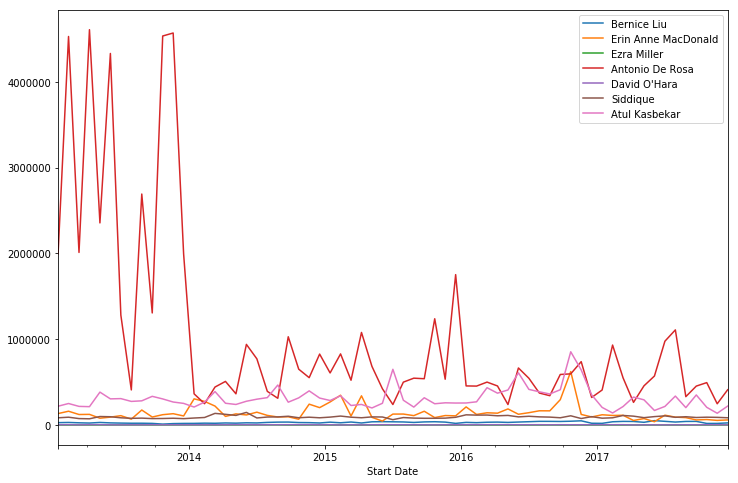

In [25]:
# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline

# fig, ax = plt.subplots(1,1, figsize=(12,8))
# all_names = []
# for name in pd.unique(df['Name']):
#     df[df['Name'] == name].plot('Start Date', 'Star Ranking', ax=ax)
#     all_names.append(name)
# ax.legend(all_names)

In [142]:
import pickle
with open("my_data.pkl", 'rb') as picklefile:
    links = list(pickle.load(picklefile))
len(links)

17546

### Scrape IMDB Page

In [91]:
from bs4 import BeautifulSoup
import requests

In [87]:
# r = requests.get('http://www.imdb.com/title/tt0137204/')
r = requests.get('http://www.imdb.com/title/tt0340855/')
soup  = BeautifulSoup(r.text)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [88]:
release_date = soup.find('meta', {'itemprop': 'datePublished'}).get_attribute_list('content')[0]
print(release_date)

2004-01-30


In [89]:
director = soup.find_all('span', {'itemprop': 'creator'})[0].text.replace('\n','')
studio = soup.find_all('span', {'itemprop': 'creator'})[1].text.replace('\n','')
print(director)
print(studio)

Patty Jenkins 
Media 8 Entertainment


In [90]:
for elem in soup.find_all('h3', {'class': 'subheading'}):
    print(elem.text)

Box Office
Company Credits
Technical Specs


In [121]:
# Read json file
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

with open('imdb_spider/test.json', 'r') as f:
    my_data = json.load(f)

imdb_info = pd.DataFrame(my_data)

imdb_mask = ((imdb_info['budget'] != '') &
             (imdb_info['metacritic_score'] != '') &
             (imdb_info['opening'] != '') &
             (~imdb_info['mpaa_rating'].isin(['', 'UNRATED', 'NOT RATED', 'TV-14'])))

imdb_info = imdb_info[imdb_mask]
imdb_info.filter('mpaa_rating NOT IN ["UNRATED", "NOT RATED", "TV-14]')

len(imdb_info)

imdb_info['budget'] = imdb_info['budget'].apply(int)
imdb_info['budget_mil'] = imdb_info['budget']/1000000.
imdb_info['opening'] = imdb_info['opening'].apply(int)
imdb_info['opening_mil'] = imdb_info['opening']/1000000.
imdb_info['metacritic_score'] = imdb_info['metacritic_score'].apply(int)
imdb_info['release'] = pd.to_datetime(imdb_info['release'].apply(lambda x: x.split('(')[0].strip()))

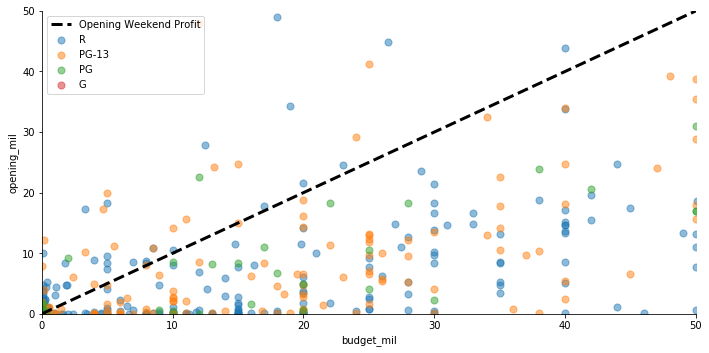

In [140]:
s = sns.lmplot(x='budget_mil', y='opening_mil', 
           data=imdb_info, 
           hue='mpaa_rating', 
           fit_reg=False, 
           size=5, 
           aspect=2, 
           scatter_kws={'alpha': 0.5, 
                        's': 50},
           legend=False);
s.ax.plot([0, 300], [0, 300], 'k--', lw=3, label='Opening Weekend Profit');
s.ax.set_xlim(0, 50)
s.ax.set_ylim(0, 50)
s.ax.legend();

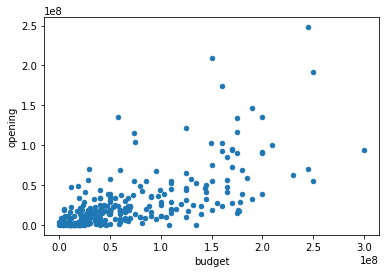

In [43]:
imdb_info.plot('budget', 'opening', kind='scatter')

In [144]:
import csv
names_data = []
with open("Data/name.basics.tsv") as fd:
    rd = csv.reader(fd, delimiter="\t", quotechar='"')
    for row in rd:
        names_data.append(row)

column_names = names_data[0]

df = pd.DataFrame(data=names_data[1:], columns=column_names)

In [146]:
df.head(20)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0050419,tt0043044,tt0053137"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0038355,tt0040506,tt0117057,tt0037382"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,producer","tt0057345,tt0049189,tt0059956,tt0063715"
3,nm0000004,John Belushi,1949,1982,"actor,writer,soundtrack","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0060827,tt0050986,tt0050976"
5,nm0000006,Ingrid Bergman,1915,1982,"actress,soundtrack,producer","tt0034583,tt0038109,tt0038787,tt0071877"
6,nm0000007,Humphrey Bogart,1899,1957,"actor,soundtrack,producer","tt0034583,tt0038355,tt0033870,tt0040897"
7,nm0000008,Marlon Brando,1924,2004,"actor,soundtrack,director","tt0068646,tt0047296,tt0078788,tt0078346"
8,nm0000009,Richard Burton,1925,1984,"actor,producer,soundtrack","tt0061184,tt0057877,tt0087803,tt0065207"
9,nm0000010,James Cagney,1899,1986,"actor,soundtrack,director","tt0042041,tt0055256,tt0029870,tt0035575"
